# An Introduction to GerryChain

GerryChain is a library for using Markov Chain Monte Carlo methods to study the problem of political redistricting. Development of the library began during the Voting Rights Data Institute (VRDI). The project is in active development in the MGGG/GerryChain GitHub repository, where bug reports and feature requests, as well as contributions, are welcome.

### Installation

To install GerryChain from PyPI, just run `pip install gerrychain`.

![](pip_install.png)

### Documentation
If you haven't done so by this point, read the documentation. It lives at https://gerrychain.readthedocs.io/en/latest/, and provides the latest information on the changes of the package, as well as examples and general guidance.

![](read_docs.png)

### Getting Started
The following mirrors the guide found in the documentation.
In order to do this, you must first download the MGGG shapefile of Pennsylvania's VTDs from GitHub: https://github.com/mggg-states/PA-shapefiles/blob/master/PA/PA_VTD.zip. Unzip this file and put it in your working directory.

![](shapefile_directory.png)

### Creating the initial partition
In order to run a Markov chain, we need an adjacency Graph of our VTD geometries and Partition of our adjacency graph into districts. This Partition will be the initial state of our Markov chain.

In [28]:
from gerrychain import Graph, Partition, Election
from gerrychain.updaters import Tally, cut_edges

graph = Graph.from_file("./PA_VTD/PA_VTD.shp")

graph.to_json("./PA_VTD.json")

election = Election("SEN12", {"Dem": "USS12D", "Rep": "USS12R"})

initial_partition = Partition(
    graph,
    assignment="2011_PLA_1",
    updaters={
        "cut_edges": cut_edges,
        "population": Tally("TOT_POP", alias="population"),
        "SEN12": election
    }
)

The above code accomplishes the following:
* The `Graph.from_file()` classmethod creates a Graph of the precincts in our shapefile. 
    * By default, this method copies all of the data columns from the shapefile’s attribute table to the graph object as node attributes. 
    * The contents of this particular shapefile’s attribute table are summarized in the mggg-states/PA-shapefiles GitHub repo.
* Depending on the size of the state, the process of generating an adjacency graph can take a bit of time. To avoid having to repeat this process in the future, we call graph.to_json() to save the graph in the NetworkX json_graph format under the name "PA_VTD.json.
* Next, we configure an `Election` object representing the 2012 Senate election, using the `USS12D` and `USS12R` vote total columns from our shapefile. The first argument is a name for the election (`"SEN12"`), and the second argument is a dictionary matching political parties to their vote total columns in our shapefile. This will let us compute hypothetical election results for each districting plan in the ensemble.
* Finally, we create a `Partition` of the graph. This will be the starting point for our Markov chain. The Partition class takes three arguments:
    1. Graph: the graph generated above
    2. Assignment: an assignment of the nodes of the graph into parts of the partition
    3. Updaters: a dictionary of possible updater functions

### Running a Chain
Now, let's configure a short (1000-step) Markov chain for testing. That would be done as follows. Note the `proposal`: `propose_random_flip`. This is one of several proposals for splitting districts as the chain runs, and we'll revisit another, the recombination step, soon. A full description of the chain's parameters is as follows, and in the documentation:

* proposal: A function that takes the current state and returns new district assignments (“flips”) for one or more nodes. This comes in the form of a dictionary mapping one or more node IDs to their new district IDs. Here we’ve used the propose_random_flip proposal, which proposes that a random node on the boundary of one district be flipped into the neighboring district.
* constraints: A list of binary constraints (functions that take a partition and return True or False) that together define which districting plans. are valid. Here we’ve used just a single constraint, single_flip_contiguous, which checks that each district in the plan is contiguous. This particular constraint is optimized for the single-flip proposal function we are using (hence the name). We could add more constraints to require that districts have nearly-equal population, to impose a bound on the compactness of the districts according to some score, or to prevent districts from splitting more counties than the original plan.
* accept: A function that takes a valid proposed state and returns True or False to signal whether the random walk should indeed move to the proposed state. always_accept always accepts valid proposed states. If you want to implement Metropolis-Hastings or any other more sophisticated acceptance criterion, you can specify your own custom acceptance function here.
* initial_state: The first state of the random walk.
* total_steps: The total number of steps to take. Invalid proposals are not counted toward this total, but rejected (by accept) valid states are.

In [29]:
from gerrychain import MarkovChain
from gerrychain.constraints import single_flip_contiguous
from gerrychain.proposals import propose_random_flip
from gerrychain.accept import always_accept

chain = MarkovChain(
    proposal = propose_random_flip,
    constraints = [single_flip_contiguous],
    accept = always_accept,
    initial_state = initial_partition,
    total_steps = 1000
)

The above code configures a Markov chain called `chain`, but does not run it yet. We run the chain by iterating through all of the states using a for loop. As an example, let’s iterate through this chain and print out the sorted vector of Democratic vote percentages in each district for each step in the chain.

In [31]:
%%capture
for partition in chain:
    print(sorted(partition["SEN12"].percents("Dem")))

To analyze the Republican vote percentages for each districting plan in our ensemble, we’ll want to actually collect the data, and not just print it out. We can use a list comprehension to store these vote percentages, and then convert it into a `pandas` DataFrame.

In [11]:
import pandas

#  Each time you iterate through a chain object, you run a new Markov Chain, just with the same configuration as the object
d_percents = [sorted(partition["SEN12"].percents("Dem")) for partition in chain]

data = pandas.DataFrame(d_percents)

The pandas DataFrame object has many helpful methods for analyzing and plotting data. For example, we can produce a boxplot of our ensemble’s Democratic vote percentage vectors, with the initial 2011 districting plan plotted in red, in just a few lines of code:

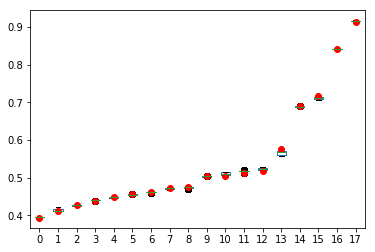

In [12]:
import matplotlib.pyplot as plt

ax = data.boxplot(positions=range(len(data.columns)))
data.iloc[0].plot(style="ro", ax=ax)

plt.show()

And that's a quick analysis using chain. Now, we'll briefly review recombination steps.

In [15]:
from gerrychain.tree_proposals import recom
from functools import partial

In [16]:
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)

Load the adjacency graph we built above:

In [17]:
graph = Graph.from_json("./PA_VTD.json")

We configure `Election` objects representing some of the election data from our shapefile.

In [18]:
elections = [
    Election("SEN10", {"Democratic": "SEN10D", "Republican": "SEN10R"}),
    Election("SEN12", {"Democratic": "USS12D", "Republican": "USS12R"}),
    Election("SEN16", {"Democratic": "T16SEND", "Republican": "T16SENR"}),
    Election("PRES12", {"Democratic": "PRES12D", "Republican": "PRES12R"}),
    Election("PRES16", {"Democratic": "T16PRESD", "Republican": "T16PRESR"})
]

### Configure Updaters
We want to set up updaters for everything we want to compute for each plan in the ensemble.

In [19]:
# Population updater, for computing how close to equality the district
# populations are. "TOT_POP" is the population column from our shapefile.
my_updaters = {"population": updaters.Tally("TOT_POP", alias="population")}

# Election updaters, for computing election results using the vote totals
# from our shapefile.
election_updaters = {election.name: election for election in elections}
my_updaters.update(election_updaters)

### Instantiating the Partition
We can now instantiate the initial state of our Markov chain, using the 2011 districting plan.

`GeographicPartition` comes with built-in `area` and `perimeter` updaters. We do not use them here, but they would allow us to compute compactness scores like Polsby-Popper that depend on these measurements.

In [20]:
initial_partition = GeographicPartition(graph, assignment="2011_PLA_1", updaters=my_updaters)

### Setting Up The Markov Chain

#### Proposal
First we’ll set up the ReCom proposal. We need to fix some parameters using functools.partial before we can use it as our proposal function.

#### Constraints
To keep districts about as compact as the original plan, we bound the number of cut edges at 2 times the number of cut edges in the initial plan.

#### Configuration
Configure the parameters for the chain as above.

In [22]:
# The ReCom proposal needs to know the ideal population for the districts so that
# we can improve speed by bailing early on unbalanced partitions.

ideal_population = sum(initial_partition["population"].values()) / len(initial_partition)

# We use functools.partial to bind the extra parameters (pop_col, pop_target, epsilon, node_repeats)
# of the recom proposal.
proposal = partial(recom,
                   pop_col="TOT_POP",
                   pop_target=ideal_population,
                   epsilon=0.02,
                   node_repeats=2
                  )

compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2*len(initial_partition["cut_edges"])
)

pop_constraint = constraints.within_percent_of_ideal_population(initial_partition, 0.02)

chain = MarkovChain(
    proposal=proposal,
    constraints=[
        pop_constraint,
        compactness_bound
    ],
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=1000
)

### Running the Chain
Now we’ll run the chain, putting the sorted Democratic vote percentages directly into a `pandas DataFrame` for analysis and plotting. The `DataFrame` will have a row for each state of the chain. The first column of the `DataFrame` will hold the lowest Democratic vote share among the districts in each partition in the chain, the second column will hold the second-lowest Democratic vote shares, and so on.

In [ ]:
%%capture
# This will take about 10 minutes.

data = pandas.DataFrame(
    sorted(partition["SEN12"].percents("Democratic"))
    for partition in chain
)

### Create a plot
Now we’ll create a box plot similar to those appearing the Virginia report.

In [ ]:
%%capture
fig, ax = plt.subplots(figsize=(8, 6))

# Draw 50% line
ax.axhline(0.5, color="#cccccc")

# Draw boxplot
data.boxplot(ax=ax, positions=range(len(data.columns)))

# Draw initial plan's Democratic vote %s (.iloc[0] gives the first row)
data.iloc[0].plot(style="ro", ax=ax)

# Annotate
ax.set_title("Comparing the 2011 plan to an ensemble")
ax.set_ylabel("Democratic vote % (Senate 2012)")
ax.set_xlabel("Sorted districts")
ax.set_ylim(0, 1)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.show()

We won't be showing the actual plot here because the chain takes some time to run, but here is what it will look like:

![](example_plot.png)

## Next Steps
Now that we've configured, run, and visualized the output of chains, the following are plausible next steps:
* Add, remove, or tweak the constraints
* Use a different proposal from GerryChain, or create your own
* Perform a similar analysis on a different districting plan for Pennsylvania
* Perform a similar analysis on a different state
* Compute partisan symmetry scores like Efficiency Gap or Mean-Median, and create a histogram of the scores of the ensemble.
* Perform the same analysis using a different election than the 2012 Senate election
* Collect Democratic vote percentages for _all_ the elections we set up, instead of just the 2012 Senate election.

For more information, be sure to consult the documentation here: https://gerrychain.readthedocs.io/en/latest/index.html